<a href="https://colab.research.google.com/github/RohithD5/CS6910_Assignment_3/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
src_url = "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"
src_zip = "dakshina_dataset_v1.0.tar"
DATA_SRC="dakshina_dataset_v1.0/ta/lexicons"
DATA_TRAIN_SRC = "/ta.translit.sampled.train.tsv"
DATA_VAL_SRC = "/ta.translit.sampled.dev.tsv" 
DATA_TEST_SRC = "/ta.translit.sampled.test.tsv"
#TRAIN_IMAGES_PER_LABEL = 1000
#TEST_IMAGES_PER_LABEL = 200
BALANCED_SPLITS = {"train" : 900, "val" : 100}
PROJECT_NAME = "CS6910 ASSIGNMENT 3"
dataset='dakshina-dataset'

In [ ]:
%%capture
!curl -SL $src_url > $src_zip
!tar -xf $src_zip

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import pandas as pd
import keras
from keras.layers import Input, LSTM, Dense, Embedding, GRU, SimpleRNN, Dropout, Activation, dot, concatenate, TimeDistributed
from keras.models import Model
import keras.backend as K
from matplotlib.font_manager import FontProperties


!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login
from wandb.keras import WandbCallback

wandb: Currently logged in as: cs6910krsrd (use `wandb login --relogin` to force relogin)


In [ ]:
import matplotlib.font_manager as fm

!wget https://github.com/arul20be/Latha-Tamil-Font/blob/master/system/fonts/NotoSansTamil-Regular.ttf
fm.fontManager.ttflist += fm.createFontList(['NotoSansTamil-Regular.ttf'])
plt.rc('font', family='NotoSansTamil-Regular-Regular')
!mv NotoSansTamil-Regular.ttf /usr/share/fonts/truetype/liberation/

In [ ]:
!fc-list :lang=en

Uploading Data: only run once

In [ ]:

run = wandb.init(project=PROJECT_NAME, entity='cs6910krsrd',job_type="upload")

# create an artifact for all the raw data
raw_data_at = wandb.Artifact(dataset, type="raw_data")

raw_data_at.add_dir(DATA_SRC)

# save artifact to W&B
run.log_artifact(raw_data_at)
run.finish()

Downloading Data

In [3]:
run = wandb.init(project=PROJECT_NAME, entity='cs6910krsrd',job_type="download")

# Query W&B for an artifact and mark it as input to this run
artifact = run.use_artifact(dataset+':latest')

# Download the artifact's contents
artifact_dir = artifact.download()
run.finish()

wandb: Currently logged in as: cs6910krsrd (use `wandb login --relogin` to force relogin)


In [4]:
MODEL_NAME = "Seq2SeqAtt"
FINAL_MODEL_DIR = "trained_model"
ENCODER="encoder"
DECODER="decoder"


colnames=["ntv","rmn",'nAtt'] #native, romanized and number of attestations
df_train = pd.read_csv(artifact_dir + DATA_TRAIN_SRC,sep="\t",names=colnames,na_filter=False)
df_val = pd.read_csv(artifact_dir + DATA_VAL_SRC,sep="\t",names=colnames,na_filter=False)
MODEL_NAME = "Seq2Seq"
FINAL_MODEL_DIR = "trained_model"


batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding and decoding space (LSTM/GRU/RNN)
num_samples = 10000  # Number of samples to train on.
embed_dim=16  #embedding size
n_encoder=2 #number of encoder layers 
n_decoder=2 #number of decoder layers
cell_type="LSTM"#"GRU" "RNN" # Cell type of encoder and decoder
do=0.2 #dropout
beam_size=3

input_texts = df_train.rmn.to_list()    # input words(romanized)
target_texts = df_train.ntv.apply(lambda s:'\t'+s+'\n').to_list() # target words(native)
input_characters = set(df_train.rmn.sum()) # input vocabulary (all english letters)
target_characters = set(df_train.ntv.sum()) # target vocabulary (all tamil letters)
val_input_texts = df_val.rmn.to_list()    # input words(romanized)
val_target_texts = df_val.ntv.apply(lambda s: s).to_list() # target words(native)
valid_target_texts = df_val.ntv.apply(lambda s:'\t'+s+'\n').to_list() # target words(native)


input_characters = sorted(list(input_characters)) 
input_characters.append(' ')
target_characters = sorted(list(target_characters))
target_characters.append(' ')
target_characters.append('\t')
target_characters.append('\n')



num_encoder_tokens = len(input_characters)   # size of input vocabulary
num_decoder_tokens = len(target_characters)   # ize of target vocabulary
max_encoder_seq_length = max([len(txt) for txt in input_texts])  # max input word size
max_decoder_seq_length = max([len(txt) for txt in target_texts]) # max output word size

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)]) #dict mapping input letters to integers
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)]) #dict mapping output letters to integers

encoder_input_data = np.zeros(                                              
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)

val_encoder_input_data = np.zeros(                                              
    (len(val_input_texts), max_encoder_seq_length), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length,len(target_token_index)), dtype="float32"
)

val_decoder_input_data = np.zeros(
    (len(val_input_texts), max_decoder_seq_length), dtype="float32"
)
val_decoder_target_data = np.zeros(
    (len(val_input_texts), max_decoder_seq_length,len(target_token_index)), dtype="float32"
)

CELL={"LSTM":LSTM,"GRU":GRU,"RNN":SimpleRNN}

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Number of samples: 68218
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28


In [5]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[char]
    encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] =  target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1,target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :] = target_token_index[" "]
    decoder_target_data[i, t:,target_token_index[" "]] =  1.0

for i, (input_text, target_text) in enumerate(zip(val_input_texts, valid_target_texts)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t] = input_token_index[char]
    val_encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t] =  target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1,target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :] = target_token_index[" "]
    val_decoder_target_data[i, t:,target_token_index[" "]] =  1.0

In [ ]:
print(decode_sequence(encoder_input_data[20:21],3))
print(input_texts[20])

போர்ஸ்

force


Attention

In [15]:
def train():

  hyperparameter_defaults={
    "epochs" : 10,
    "num_samples" : 10000,
    "embed_dim" : 64,
    "n_encoder" : 1,
    "n_decoder" : 1,
    "drop_out" : 0.2,
    'latent_dim':128,
    'beam_size':0,
    'batch_size':64,
    'cell_type':"LSTM"
    }

  run = wandb.init(project=PROJECT_NAME, config=hyperparameter_defaults, entity='cs6910krsrd',job_type="train")


  cfg = wandb.config
  batch_size = cfg.batch_size  # Batch size for training.
  epochs = cfg.epochs  # Number of epochs to train for.
  latent_dim = cfg.latent_dim  # Latent dimensionality of the encoding and decoding space (LSTM/GRU/RNN)
  num_samples = cfg.num_samples  # Number of samples to train on.
  embed_dim=cfg.embed_dim#embedding size
  n_encoder=cfg.n_encoder #number of encoder layers 
  n_decoder=cfg.n_decoder #number of decoder layers
  cell_type=cfg.cell_type#"GRU" "RNN" # Cell type of encoder and decoder
  do=cfg.drop_out #dropout
  beam_size=cfg.beam_size

  encoder_inputs=Input(shape=(None,))
  x = Embedding(num_encoder_tokens, embed_dim)(encoder_inputs)
  encoder_states = []
  x, state_h, state_c = CELL[cell_type](latent_dim,dropout=do,return_state=True,return_sequences=True)(x)
  encoder= x #[x, state_h, state_c]
  encoder_states = [state_h, state_c]

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))
  out_embed=Embedding(num_decoder_tokens, embed_dim)
  embedded_word=out_embed(decoder_inputs)
  x=embedded_word
  output_layers = []
  output_layers.append(
        CELL[cell_type](latent_dim,dropout=do, return_sequences=True,return_state=True)
  )
  x,dh,dc = output_layers[-1](x, initial_state=encoder_states)
  decoder= x#[x,dh,dc]

  attention = dot([decoder, encoder], axes=[2, 2])
  visualization=attention
  attention = Activation('softmax')(visualization)
  context = dot([attention, encoder], axes=[2,1])
  decoder_combined_context = concatenate([context, decoder])

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')
  output=decoder_dense(decoder_combined_context)

  """#timedistributed?
  decoder_dense1=TimeDistributed(Dense(latent_dim, activation="tanh"))
  decoder_dense2=TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))
  output = decoder_dense1(decoder_combined_context)
  output = decoder_dense2(output)"""

  """dropout = Dropout(rate=do)
  x = dropout(x)
  decoder_dense = Dense(num_decoder_tokens, activation='softmax')   #time_distributed?
  decoder_outputs = decoder_dense(x)"""

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = Model([encoder_inputs, decoder_inputs], output)

  model.compile(
      optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
  )
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.2,
  )

  encoder_model = Model(encoder_inputs, [encoder,encoder_states])
  #n_decoder=1

  decoder_inputs = Input(shape=(None,))
  embedded_word=out_embed(decoder_inputs)

  decoder_states_inputs = []
  decoder_states = []
  d_outputs=embedded_word
  current_state_inputs = [Input(shape=(latent_dim,)) for _ in range(2)]
  encoder_outs=Input(shape=(None,latent_dim,))

  temp = output_layers[0](d_outputs, initial_state=current_state_inputs)

  d_outputs, cur_states = temp[0], temp[1:]
  decoder_states += cur_states
  decoder_states_inputs += current_state_inputs

  attention_inf = dot([d_outputs, encoder_outs], axes=[2, 2])

  attention_inf = Activation('softmax')(attention_inf)

  visualization=attention_inf

  context_inf = dot([attention_inf, encoder_outs], axes=[2,1])

  decoder_combined_context_inf = concatenate([context_inf, d_outputs])

  dec_output=decoder_dense(decoder_combined_context_inf)



  decoder_model = Model(
      [encoder_outs]+[decoder_inputs] + decoder_states_inputs,
      [dec_output]+ [visualization] + decoder_states)



  # Reverse-lookup token index to decode sequences back to
  # something readable.
  reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
  reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

  

  trained_model_artifact = wandb.Artifact(
            MODEL_NAME+"trn", type="model",
            description="trained model",
            metadata=dict(cfg))
  
  encoder_artifact = wandb.Artifact(
            MODEL_NAME+"enc", type="model",
            description="encoder",
            metadata=dict(cfg))
  
  decoder_artifact = wandb.Artifact(
            MODEL_NAME+"dec", type="model",
            description="decoder",
            metadata=dict(cfg))
  
  model.save(FINAL_MODEL_DIR)
  encoder_model.save(ENCODER)
  decoder_model.save(DECODER)

  trained_model_artifact.add_dir(FINAL_MODEL_DIR)
  encoder_artifact.add_dir(ENCODER)
  decoder_artifact.add_dir(DECODER)


  run.log_artifact(trained_model_artifact)
  run.log_artifact(encoder_artifact)
  run.log_artifact(decoder_artifact)
  run.finish()

In [ ]:
train()

In [ ]:
def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z

def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

In [ ]:
def calcValAcc(encoder_model,decoder_model):
  encoder_model = Model(encoder_inputs, encoder_states)

  decoder_states_inputs = []
  decoder_states = []
  d_outputs=embedded_word
  for j in range(n_decoder)[::-1]:
    current_state_inputs = [Input(shape=(latent_dim,)) for _ in range(2)]

    temp = output_layers[n_decoder-j-1](d_outputs, initial_state=current_state_inputs)

    d_outputs, cur_states = temp[0], temp[1:]
    decoder_states += cur_states
    decoder_states_inputs += current_state_inputs

  decoder_outputs = decoder_dense(d_outputs)
  decoder_model = Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs] + decoder_states)

  # Reverse-lookup token index to decode sequences back to
  # something readable.
  correct_pred=list()

  for seq_index in range(len(val_encoder_input_data)):
    input_seq = val_encoder_input_data[seq_index : seq_index + 1]
    pred=decode_sequence(input_seq, beam_size,encoder_model,decoder_model)
    #print(input_seq,"pred:",pred,"true",val_target_texts[seq_index:seq_index+1])
    #print("yay",pred,val_target_texts[seq_index])
    if pred==val_target_texts[seq_index:seq_index+1]:
      correct_pred.append(1)
      #print("correctpred")
    else:
      correct_pred.append(0)
    
  val_accuracy=np.mean(np.array(correct_pred))

  print(val_accuracy)
  return(val_accuracy)


In [ ]:
def calcValAcc(encoder_model,decoder_model):
  encoder_model = Model(encoder_inputs, encoder_states)

  decoder_states_inputs = []
  decoder_states = []
  d_outputs=embedded_word
  for j in range(n_decoder)[::-1]:
    current_state_inputs = [Input(shape=(latent_dim,)) for _ in range(2)]

    temp = output_layers[n_decoder-j-1](d_outputs, initial_state=current_state_inputs)

    d_outputs, cur_states = temp[0], temp[1:]
    decoder_states += cur_states
    decoder_states_inputs += current_state_inputs

  decoder_outputs = decoder_dense(d_outputs)
  decoder_model = Model(
      [decoder_inputs] + decoder_states_inputs,
      [decoder_outputs] + decoder_states)

  # Reverse-lookup token index to decode sequences back to
  # something readable.
  correct_pred=list()

  for seq_index in range(len(val_encoder_input_data)):
    input_seq = val_encoder_input_data[seq_index : seq_index + 1]
    pred=decode_sequence(input_seq, beam_size,encoder_model,decoder_model)
    #print(input_seq,"pred:",pred,"true",val_target_texts[seq_index:seq_index+1])
    #print("yay",pred,val_target_texts[seq_index])
    if pred==val_target_texts[seq_index:seq_index+1]:
      correct_pred.append(1)
      #print("correctpred")
    else:
      correct_pred.append(0)
    
  val_accuracy=np.mean(np.array(correct_pred))

  print(val_accuracy)
  return(val_accuracy)


In [ ]:
run = wandb.init(project=PROJECT_NAME, job_type="inference")
enc_model_at = run.use_artifact('cs6910krsrd/CS6910 ASSIGNMENT 3/Seq2Seqenc:v1', type='model')
model_dir= enc_model_at.download()
encoder_model=tf.keras.models.load_model(model_dir)
dec_model_at = run.use_artifact('cs6910krsrd/CS6910 ASSIGNMENT 3/Seq2Seqdec:v1', type='model')
model_dir= dec_model_at.download()
decoder_model=tf.keras.models.load_model(model_dir)

run.finish()

In [ ]:
encoder_inputs=Input(shape=(None,))
x = Embedding(num_encoder_tokens, embed_dim)(encoder_inputs)
encoder_states = []
x, state_h, state_c = CELL[cell_type](latent_dim,dropout=do,return_state=True,return_sequences=True)(x)
encoder= x #[x, state_h, state_c]
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
out_embed=Embedding(num_decoder_tokens, embed_dim)
embedded_word=out_embed(decoder_inputs)
x=embedded_word
output_layers = []
output_layers.append(
      CELL[cell_type](latent_dim,dropout=do, return_sequences=True,return_state=True)
)
x,dh,dc = output_layers[-1](x, initial_state=encoder_states)
decoder= x#[x,dh,dc]

attention = dot([decoder, encoder], axes=[2, 2])
visualization=attention
attention = Activation('softmax')(visualization)
context = dot([attention, encoder], axes=[2,1])
decoder_combined_context = concatenate([context, decoder])

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
output=decoder_dense(decoder_combined_context)

"""#timedistributed?
decoder_dense1=TimeDistributed(Dense(latent_dim, activation="tanh"))
decoder_dense2=TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))
output = decoder_dense1(decoder_combined_context)
output = decoder_dense2(output)"""

"""dropout = Dropout(rate=do)
x = dropout(x)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')   #time_distributed?
decoder_outputs = decoder_dense(x)"""

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], output)

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s_tamil")

  encoder_model = Model(encoder_inputs, [encoder,encoder_states])
  #n_decoder=1

  decoder_inputs = Input(shape=(None,))
  embedded_word=out_embed(decoder_inputs)

  decoder_states_inputs = []
  decoder_states = []
  d_outputs=embedded_word
  current_state_inputs = [Input(shape=(latent_dim,)) for _ in range(2)]
  encoder_outs=Input(shape=(None,latent_dim,))

  temp = output_layers[0](d_outputs, initial_state=current_state_inputs)

  d_outputs, cur_states = temp[0], temp[1:]
  decoder_states += cur_states
  decoder_states_inputs += current_state_inputs

  attention_inf = dot([d_outputs, encoder_outs], axes=[2, 2])

  attention_inf = Activation('softmax')(attention_inf)

  visualization=attention_inf

  context_inf = dot([attention_inf, encoder_outs], axes=[2,1])

  decoder_combined_context_inf = concatenate([context_inf, d_outputs])

  dec_output=decoder_dense(decoder_combined_context_inf)



  decoder_model = Model(
      [encoder_outs]+[decoder_inputs] + decoder_states_inputs,
      [dec_output]+ [visualization] + decoder_states)



  # Reverse-lookup token index to decode sequences back to
  # something readable.
  reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
  reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())



# Save model
model.save("s2s_tamil")

Epoch 1/20
853/853 [==============================] - 13s 12ms/step - loss: 1.1034 - accuracy: 0.7137 - val_loss: 0.8015 - val_accuracy: 0.7969
Epoch 2/20
853/853 [==============================] - 9s 11ms/step - loss: 0.5164 - accuracy: 0.8472 - val_loss: 0.5569 - val_accuracy: 0.8754
Epoch 3/20
853/853 [==============================] - 9s 11ms/step - loss: 0.2679 - accuracy: 0.9265 - val_loss: 0.4260 - val_accuracy: 0.9087
Epoch 4/20
853/853 [==============================] - 10s 11ms/step - loss: 0.1537 - accuracy: 0.9590 - val_loss: 0.3882 - val_accuracy: 0.9171
Epoch 5/20
853/853 [==============================] - 10s 11ms/step - loss: 0.1138 - accuracy: 0.9692 - val_loss: 0.3984 - val_accuracy: 0.9144
Epoch 6/20
853/853 [==============================] - 9s 11ms/step - loss: 0.0918 - accuracy: 0.9748 - val_loss: 0.4404 - val_accuracy: 0.9031
Epoch 7/20
853/853 [==============================] - 9s 11ms/step - loss: 0.0786 - accuracy: 0.9780 - val_loss: 0.4795 - val_accuracy: 0.8

INFO:tensorflow:Assets written to: s2s_tamil/assets


INFO:tensorflow:Assets written to: s2s_tamil/assets


In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s_tamil")

encoder_model = Model(encoder_inputs, [encoder,encoder_states])
#n_decoder=1

decoder_inputs = Input(shape=(None,))
embedded_word=out_embed(decoder_inputs)

decoder_states_inputs = []
decoder_states = []
d_outputs=embedded_word
current_state_inputs = [Input(shape=(latent_dim,)) for _ in range(2)]
encoder_outs=Input(shape=(None,latent_dim,))

temp = output_layers[0](d_outputs, initial_state=current_state_inputs)

d_outputs, cur_states = temp[0], temp[1:]
decoder_states += cur_states
decoder_states_inputs += current_state_inputs

attention_inf = dot([d_outputs, encoder_outs], axes=[2, 2])

attention_inf = Activation('softmax')(attention_inf)

visualization=attention_inf

context_inf = dot([attention_inf, encoder_outs], axes=[2,1])

decoder_combined_context_inf = concatenate([context_inf, d_outputs])

dec_output=decoder_dense(decoder_combined_context_inf)



decoder_model = Model(
    [encoder_outs]+[decoder_inputs] + decoder_states_inputs,
    [dec_output]+ [visualization] + decoder_states)



# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())




In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    temp= (encoder_model.predict(input_seq))

    e_out=temp[0]

    states_value=temp[1:]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    vis_list=list()
    end_char_ind=np.max(input_seq[0])
    for i in range(len(input_seq[0])):
      if input_seq[0][i] == end_char_ind:
        break

    while not stop_condition:
        #print("a",np.shape([target_seq] + states_value))
        output_tokens, visualization, h, c = decoder_model.predict([e_out]+[target_seq] + states_value)


        vis_list.append(visualization[0][0][:i+1])


        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    n_dots=np.array(np.shape(vis_list))
    print(n_dots*10)
    mat=np.zeros(n_dots*10)

    print(np.shape(mat))
    xt=list()
    yt=list()

    if plot=True
    fig, ax = plt.subplots()
    for i,vis in enumerate(vis_list):
      for j, color in enumerate(vis):
        mat[i*10:i*10+10,j*10:j*10+10]=color
        yt.append(j*10+5)
        xt.append(i*10+5)
        
    
    ax.imshow(mat)
    ax.set_xticks(yt)
    ax.set_yticks(xt)

    print([reverse_input_char_index[token] for token in input_seq[0][:i]])

    ax.set_xticklabels([reverse_input_char_index[token] for token in input_seq[0][:i]])
    ax.set_yticklabels(decoded_sentence)


    
    plt.show()

    return decoded_sentence

In [202]:
def connectivity(input_seq,beam_size,plot=False):
    # Encode the input as state vectors.
    temp= (encoder_model.predict(input_seq))

    k=beam_size

    e_out=temp[0]

    states_value=temp[1:]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    vis_list=list()
    end_char_ind=np.max(input_seq[0])
    for in_size in range(len(input_seq[0])):
      if input_seq[0][in_size] == end_char_ind:
        break

    end_index=target_token_index["\n"] #sample index to check for end



    sequences=[[list(),0.0,states_value,False,list()]]

    while not stop_condition:

        
        new_sequences=list()
        stop_condition=True
        #print("a",np.shape([target_seq] + states_value)) 
        #print("a",np.shape([target_seq] + states_value))
        for i in range(len(sequences)):
          seq, score, states_value,stop_seq, vis_list = sequences[i].copy()

          if stop_seq:
            new_sequences.append(sequences[i])

          else:
            stop_condition=False                                         #if atleast one sequence is unfinished, decoding must continue
            if len(seq)!=0:                                              #dont run for first iteration
              sampled_token_index=seq[-1]
              target_seq = np.zeros((1, 1))
              target_seq[0, 0] = sampled_token_index
              
            output_tokens, visualization, h, c = decoder_model.predict([e_out]+[target_seq] + states_value)
            v=vis_list.copy()
            v.append(visualization[0][0][:in_size+1])

            output_tokens=output_tokens[0, -1, :]
            new_states_value=[h,c]


            for j in range(len(output_tokens)):
              if j == end_index or len(seq) > max_decoder_seq_length:
                new_seq = [seq + [j], score - np.log(output_tokens[j]),new_states_value,True,v]
              else:
                new_seq = [seq + [j], score - np.log(output_tokens[j]),new_states_value,False,v]
              new_sequences.append(new_seq)

        ordered = sorted(new_sequences, key=lambda tup:tup[1])

        sequences = ordered[:k]
        print(np.shape(sequences[0][-1]))


    best_seq=sequences[0][0]
    for sampled_token_index in best_seq:
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += sampled_char

    #print(sequences[0])

    vis_list=sequences[0][-1]
    n_dots=np.array(np.shape(vis_list))
    print(n_dots*10)
    mat=np.zeros(n_dots*10)
    #print(vis_list)
    print(np.shape(mat))
    xt=list()
    yt=list()

    if plot==True:
      fig, ax = plt.subplots()
      for i,vis in enumerate(vis_list):
        yt=list()
        for j, color in enumerate(vis):
          mat[i*10:i*10+10,j*10:j*10+10]=color
          yt.append(j*10+5)
        xt.append(i*10+5)

      print(xt)
          
      
      ax.imshow(mat)
      ax.set_xticks(yt)
      ax.set_yticks(xt)

      ax.set_xticklabels(list([reverse_input_char_index[token] for token in input_seq[0][:i]]))
      ax.set_yticklabels(best_seq)
      fontproperties=FontProperties(fname="fonts/Catamaran-Light.ttf")

      print(best_seq)
      


    
      plt.show()


    return (decoded_sentence,vis_list)

[1.5640503e-12 5.9979907e-14 1.1153970e-13 2.5718112e-16 1.5900840e-16
 2.1817437e-16 2.0342529e-16 2.1156110e-16 1.7764053e-17 1.9721919e-16
 1.2869725e-16 5.1608464e-18 1.6746781e-16]
(1, 13)
[1.2287646e-06 2.8592896e-07 2.7427620e-07 1.2355887e-09 5.3534810e-10
 2.7489375e-10 7.2838796e-10 4.5467630e-09 2.3723373e-10 8.7151525e-10
 2.6312990e-09 1.9118776e-10 3.6650756e-09]
[4.8709671e-06 5.9778569e-07 5.9092213e-07 9.7830206e-09 5.2733973e-09
 3.3348531e-09 9.7176311e-09 1.5217324e-07 9.4047037e-09 4.3634344e-08
 2.3847309e-07 9.9222879e-09 1.9735884e-07]
[1.1098623e-04 4.4745661e-06 1.4161812e-05 2.3137437e-07 3.4455532e-08
 2.9154595e-08 3.6721541e-08 3.9924868e-07 9.1421313e-08 3.1458123e-07
 1.1359780e-06 5.5336361e-08 5.2048813e-07]
(2, 13)
[1.4676311e-04 4.9110959e-06 5.9219896e-05 3.6434824e-06 1.1618446e-06
 1.3275719e-06 1.6630154e-06 8.3134953e-05 3.6012129e-06 5.3424905e-05
 8.9749967e-04 2.7945340e-05 8.5939461e-04]
[4.20165947e-04 1.50031265e-05 1.69190651e-04 7.391134

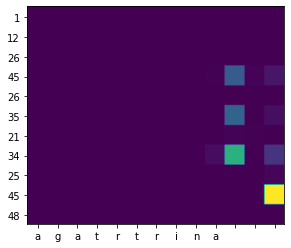

In [201]:
res, vis=connectivity(val_encoder_input_data[10:11],3,True)

In [198]:
vis

[array([1.5640503e-12, 5.9979907e-14, 1.1153970e-13, 2.5718112e-16,
        1.5900840e-16, 2.1817437e-16, 2.0342529e-16, 2.1156110e-16,
        1.7764053e-17, 1.9721919e-16, 1.2869725e-16, 5.1608464e-18,
        1.6746781e-16], dtype=float32),
 array([1.2287646e-06, 2.8592896e-07, 2.7427620e-07, 1.2355887e-09,
        5.3534810e-10, 2.7489375e-10, 7.2838796e-10, 4.5467630e-09,
        2.3723373e-10, 8.7151525e-10, 2.6312990e-09, 1.9118776e-10,
        3.6650756e-09], dtype=float32),
 array([1.4676311e-04, 4.9110959e-06, 5.9219896e-05, 3.6434824e-06,
        1.1618446e-06, 1.3275719e-06, 1.6630154e-06, 8.3134953e-05,
        3.6012129e-06, 5.3424905e-05, 8.9749967e-04, 2.7945340e-05,
        8.5939461e-04], dtype=float32),
 array([1.3924128e-04, 3.7361390e-06, 2.9859380e-04, 1.0539969e-05,
        4.9054356e-06, 3.9406023e-06, 9.4824672e-06, 5.6492438e-04,
        4.1820098e-05, 2.6545471e-03, 1.4494491e-01, 4.5870072e-03,
        2.9872844e-02], dtype=float32),
 array([4.0245820e-07, 5

In [178]:
print(connectivity(encoder_input_data[20:21],3,False)[0])


print(input_texts[20])

[190  60]
(190, 60)
போர்ஸ்

force


In [199]:
res

'அகற்றினார்\n'

Connectivity

In [144]:
def visualize(output_values, result_list, input):
  text_colours = []
  for j in range(len(result_list)):
    text_colours = []

    for i in range(len(input)):
      text = (input[i], get_clr(output_values[j][i]))
      print(output_values[j][i])
      text_colours.append(text)
    print_color(text_colours)

In [103]:
from IPython.display import HTML as html_print
from IPython.display import display

In [139]:
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	


def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z

In [204]:
visualize(vis, res, val_input_texts[10:11][0])

0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308
0.07692308


0.076923154
0.076923095
0.076923095
0.076923065
0.076923065
0.076923065
0.076923065
0.076923065
0.076923065
0.076923065
0.076923065
0.076923065


0.07692169
0.07691077
0.076914944
0.076910675
0.07691048
0.07691049
0.07691052
0.07691678
0.076910675
0.0769145
0.07697944
0.076912545


0.07579895
0.07578868
0.07581102
0.07578918
0.075788766
0.075788684
0.07578911
0.07583121
0.07579156
0.07598984
0.087609544
0.07613683


0.07692206
0.07692203
0.07692207
0.07692203
0.076922044
0.07692205
0.07692213
0.0769227
0.07692217
0.076924056
0.07692935
0.076922566


0.075795256
0.07577633
0.07578076
0.075775325
0.07577523
0.07577525
0.0757754
0.07578155
0.07577678
0.075907335
0.08898769
0.07589459


0.07686112
0.07685066
0.07684848
0.07684579
0.07685584
0.07685574
0.07698602
0.07692353
0.076912254
0.07697208
0.07720373
0.07701397


0.074220486
0.074194156
0.07418998
0.0741843
0.07418539
0.07418748
0.074206114
0.07426278
0.07420821
0.075443484
0.10227538
0.0743103


0.076899424
0.07691176
0.07688052
0.07687626
0.07687888
0.07688731
0.076895215
0.076885775
0.0768881
0.07688525
0.076884575
0.076875776


0.07322463
0.07322685
0.073226295
0.0732268
0.07323194
0.07323084
0.07323495
0.073257625
0.07326917
0.0733066
0.073300295
0.07323164


0.07692166
0.0769256
0.07692397
0.07692186
0.07692567
0.076924905
0.076924905
0.07692159
0.07692235
0.076922506
0.07692126
0.07692125


In [115]:
val_input_texts[20:21][0]

'angkeekaaraththai'

In [125]:
np.shape(vis)

(37, 18)

In [152]:
def sm(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [203]:
for i in range(len(vis)):
  vis[i]=sm(vis[i])

In [205]:
vis

[array([0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308], dtype=float32),
 array([0.07692315, 0.07692309, 0.07692309, 0.07692306, 0.07692306,
        0.07692306, 0.07692306, 0.07692306, 0.07692306, 0.07692306,
        0.07692306, 0.07692306, 0.07692306], dtype=float32),
 array([0.07692169, 0.07691077, 0.07691494, 0.07691067, 0.07691048,
        0.07691049, 0.07691052, 0.07691678, 0.07691067, 0.0769145 ,
        0.07697944, 0.07691254, 0.07697652], dtype=float32),
 array([0.07579895, 0.07578868, 0.07581102, 0.07578918, 0.07578877,
        0.07578868, 0.07578911, 0.07583121, 0.07579156, 0.07598984,
        0.08760954, 0.07613683, 0.07808656], dtype=float32),
 array([0.07692206, 0.07692203, 0.07692207, 0.07692203, 0.07692204,
        0.07692205, 0.07692213, 0.0769227 , 0.07692217, 0.07692406,
        0.07692935, 0.07692257, 0.07692465], dtype=float32),
 array([0.07579